In [364]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from netwulf import visualize
import numpy as np
import datetime
import netwulf as nw

In [3]:
df = pd.read_pickle("E:/KPop/Processed_Data/all_tweets.pkl")
df = df[["tweetid", "screen_name", "rt_screen", "date", "userid", "rt_userid", "country", "state", "rt_state", "rt_country"]]

In [132]:
UP = pd.read_pickle("../COVID-19/Bots/Weighted_Pol_LPA")
B = pd.read_csv("../COVID-19/Bots/raw_scores-english.csv")
B = B[~B.id_str.isna()]
B.id_str = B.id_str.astype(np.int64)
B.drop_duplicates("id_str", inplace= True)
B["is_bot"] = B.overall > 0.5
UP = UP[~UP.Weighted_Pol_LPA.isna() ]
UP["Pos_Orig"] = np.sign((UP.Weighted_Pol-2).values)
UP["Pos_LPA"] = np.sign((UP.Weighted_Pol_LPA-2).values)

id2Bot = dict(zip(B.id_str.values, B.is_bot.values))
id2pol = dict(zip(UP.userids.values, UP.Pos_LPA.values))

C:\Users\User\anaconda3\envs\networks\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sign
  


In [8]:
# E = pd.read_pickle("edge_list.pkl")
# E.columns = ["userid","rt_userid","weight"]

In [4]:
%config Completer.use_jedi = False

In [66]:
def convert_to_int(x):
    try:
        return np.int64(x)
    except:
        return np.nan

In [6]:
df.userid = df.userid.apply(convert_to_int)
df = df[~df.userid.isna()]

In [43]:
# # E = df[["userid","rt_userid"]]
# E = df2[["userid","rt_userid"]]
# E = E[~E.rt_userid.isna()]
# E.rt_userid = E.rt_userid.astype(np.int64)
# E.userid = E.userid.apply(convert_to_int)
# E = E[~E.rt_userid.isna()]
# E = E[~E.userid.isna()]
# E = E.astype(np.int64)
# E, counts = np.unique(E.values, axis=0, return_counts=True)
# E = np.hstack((E,np.atleast_2d(counts).T))
# E = pd.DataFrame(E, columns=["userid","rt_userid","counts"])

In [336]:
# df2 = pd.read_pickle("E:/KPop/Processed_Data/mask_tweets.pkl")

In [423]:
df2 = pd.read_pickle("E:/KPop/Processed_Data/mask_tweets.pkl")
df2["user_pol"] = df2.userid.apply(lambda x: id2pol.get(x,np.nan))
df2["rt_user_pol"] = df2.rt_userid.apply(lambda x: id2pol.get(x,np.nan))
df2 = df2[~df2.user_pol.isna()]
df2 = df2[~df2.rt_user_pol.isna()]
id2name  = dict(zip(df2.userid.values,df2.screen_name.values))

In [463]:
# E1 = df2[df2.date <= "2020-08-21"][["userid","rt_userid"]]
# E2 = df2[df2.date > "2020-08-21"][["userid","rt_userid"]]

E1 = df2[(df2.date <= "2020-08-20") & (df2.date > "2020-05-20")][["userid","rt_userid"]]
E2 = df2[(df2.date > "2020-08-20") & (df2.date <= "2020-11-20")][["userid","rt_userid"]]

In [426]:
def process_edge_list(EE):
    EE = EE[~EE.rt_userid.isna()]
    EE.rt_userid = EE.rt_userid.astype(np.int64)
    EE.userid = EE.userid.apply(convert_to_int)
    EE = EE[~EE.rt_userid.isna()]
    EE = EE[~EE.userid.isna()]
    EE.userid = EE.userid.astype(np.int64)
    EE.rt_userid = EE.rt_userid.astype(np.int64)
    EE, counts = np.unique(EE.values, axis=0, return_counts=True)
    EE = np.hstack((EE,np.atleast_2d(counts).T))
    EE = pd.DataFrame(EE, columns=["userid","rt_userid","counts"])
    return EE

def get_k_core(E_RT,K=10):
    E = E_RT.copy()
    old_len = len(E) + 1
#     for i in range(40):
    while old_len > len(E):
        old_len = len(E)
        print(old_len)

        rt = E.rt_userid.values
        vals, counts = np.unique(rt, return_counts = True) # unweighted k-core
        good_ids = vals[counts >= K]

        mask1 = np.in1d(E.userid.values, good_ids)
        mask2 = np.in1d(E.rt_userid.values, good_ids)
        mask3 = E.userid.values != E.rt_userid.values
        mask = mask1 & mask2 & mask3

        E = E[mask]
    return E

In [464]:
E1 = process_edge_list(E1)
E2 = process_edge_list(E2)

E1 = get_k_core(E1,1) # retweeted at least once
E2 = get_k_core(E2,1)

# E1 = E1[ E1.counts > 1 ]
# E2 = E2[ E2.counts > 1 ]

58792
1406
428
270
226
223
222
97570
1842
543
383
349
336
332


In [465]:
G1 = nx.DiGraph()
G1.add_weighted_edges_from(E1.values)
# G1 = G1.reverse()

G2 = nx.DiGraph()
G2.add_weighted_edges_from(E2.values)
# G2 = G2.reverse()

In [446]:
%%time
G1_U = G1.to_undirected()
G1_U.remove_edges_from(nx.selfloop_edges(G1_U))
G1_U = nx.k_core(G1_U, k = 3)

G2_U = G2.to_undirected()
G2_U.remove_edges_from(nx.selfloop_edges(G2_U))
G2_U = nx.k_core(G2_U, k = 3)

Wall time: 4.13 s


In [466]:
pol2color = {-1:"blue", 1:"red", 0:"LightCoral"}

In [467]:
for k, v in G1.nodes(data=True):
    v["group"] = pol2color[id2pol[k] ]
    v['label'] = id2name.get(k, "none")
    
for k, v in G2.nodes(data=True):
    v["group"] = pol2color[id2pol[k] ]
    v['label'] = id2name.get(k, "none")

In [468]:
stylized_network, config = visualize(G1)

In [469]:
stylized_network, config = visualize(G2)

In [443]:
for k, v in G1_U.nodes(data=True):
    v["group"] = pol2color[id2pol[k] ]
    v['label'] = id2name.get(k, "none")
    
for k, v in G2_U.nodes(data=True):
    v["group"] = pol2color[id2pol[k] ]
    v['label'] = id2name.get(k, "none")

In [450]:
stylized_network, config = visualize(G1_U)

In [452]:
stylized_network, config = visualize(G2_U)

In [477]:
df2 = pd.read_pickle("E:/KPop/Processed_Data/mask_tweets.pkl")
df2["user_pol"] = df2.userid.apply(lambda x: id2pol.get(x,np.nan))
df2["rt_user_pol"] = df2.rt_userid.apply(lambda x: id2pol.get(x,np.nan))
df2 = df2[~df2.user_pol.isna()]
# df2 = df2[~df2.rt_user_pol.isna()]
df2["bts"] = df2.text.apply(lambda x: "bts" in x.lower())

In [393]:
W1 = df2[(df2.date <= "2020-08-20") & (df2.date > "2020-08-13")]
W2 = df2[(df2.date > "2020-08-20") & (df2.date <= "2020-08-27")]

In [394]:
tt = pd.date_range("2020-04-01", "2021-04-01", freq="30D")

In [504]:
%%time
ts_users = []
ts_rt_users = []
SE_users = []
SE_rt_users = []

for i,t in enumerate(tt[:-2]):
    W = df2[(df2.date.dt.date <= tt[i+1]) & (df2.date.dt.date > t)]
    ts_rt_users.append(W.rt_user_pol.mean())
    ts_users.append(W.user_pol.mean())
    
    SE_users.append(  W.user_pol.std() / np.sqrt((~W.user_pol.isna()).sum())  )
    SE_rt_users.append( W.rt_user_pol.std() / np.sqrt((~W.rt_user_pol.isna()).sum())  )

Wall time: 10.5 s


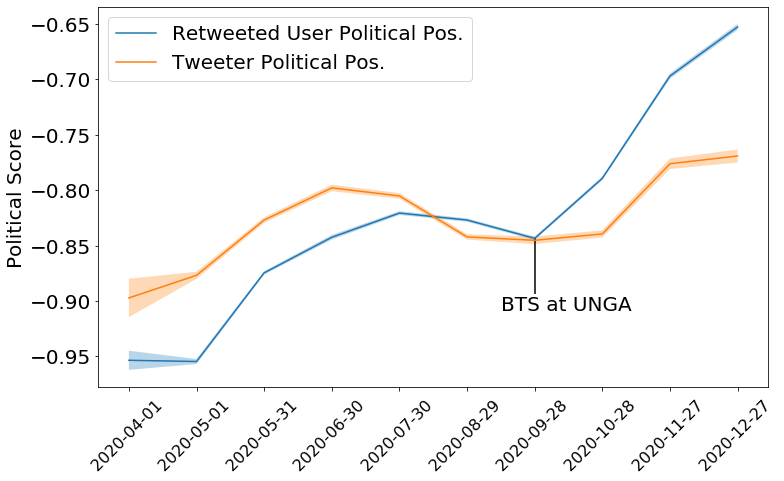

In [545]:
plt.figure(figsize=(12,7))
plt.plot(ts_rt_users[1:], label="Retweeted User Political Pos.")
plt.plot(ts_users[1:], label="Tweeter Political Pos.")
plt.xticks(range(len(tt[:-2])),[str(x)[:11] for x in tt[:-2]],rotation=45, fontsize=16)
plt.vlines(6,ts_rt_users[7],ts_rt_users[7]-0.05)
plt.annotate("BTS at UNGA", (6-0.5,ts_rt_users[7]-0.065), fontsize=20)

a, b = (ts_rt_users - SE_users), (ts_rt_users + SE_users)
plt.fill_between(range(len(tt[:-3])), a[1:], b[1:],  alpha = 0.3 )

a, b = (ts_users - SE_rt_users), (ts_users + SE_rt_users)
plt.fill_between(range(len(tt[:-3])), a[1:], b[1:],  alpha = 0.3 )

plt.legend(fontsize=20)
plt.ylabel("Political Score", fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("figures/Political_Score.png",bbox_inches="tight")

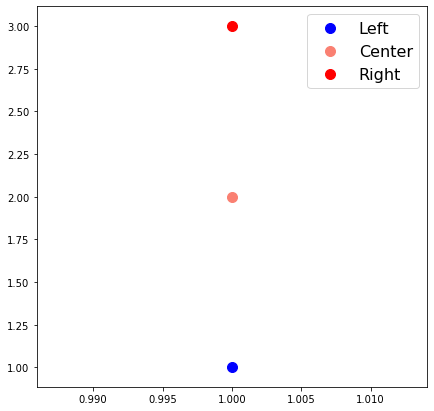

In [552]:
plt.figure(figsize=(7,7))
plt.scatter(1,1,label="Left",color="blue", s=100)
plt.scatter(1,2,label="Center",color="salmon", s=100)
plt.scatter(1,3,label="Right",color="red", s=100)
plt.legend(fontsize=16)

In [486]:
W1 = df2[(df2.date <= "2020-08-20") & (df2.date > "2020-04-20")]
W2 = df2[(df2.date > "2020-08-20") & (df2.date <= "2020-12-20")]

In [489]:
W1.rt_user_pol.mean(), W1.rt_user_pol.std(), W2.rt_user_pol.mean(), W2.rt_user_pol.std()

(-0.8670388066291373,
 0.47907638186703794,
 -0.832958565579474,
 0.5037103997464304)

In [490]:
W1_b = W1[W1.bts]
W2_b = W2[W2.bts]

In [491]:
len(W2_b), W2_b.rt_user_pol.mean(), W2_b.rt_user_pol.std()

(12290, -0.9996081504702194, 0.02799325416975541)

In [344]:
len(W1_b), W1_b.rt_user_pol.mean(), W1_b.rt_user_pol.std()

(4, -1.0, 0.0)

In [ ]:
%%time
get_color =  lambda x: "red" if x in W3_userid else "blue"
for k, v in G.nodes(data=True):
#     v['label'] = id2name[k]
    v["W1"] = k in W1_userid
    v["group"] =get_color(k)
    v["W2"] = k in W2_userid
    v["W3"] = k in W3_userid

In [461]:
# %%time
def get_k_core(E_RT,K=10):
    E = E_RT.copy()
    old_len = len(E) + 1
#     for i in range(40):
    while old_len > len(E):
        old_len = len(E)
        print(old_len)

        rt = E.rt_userid.values
        vals, counts = np.unique(rt, return_counts = True) # unweighted k-core
        good_ids = vals[counts >= K]

        mask1 = np.in1d(E.userid.values, good_ids)
        mask2 = np.in1d(E.rt_userid.values, good_ids)
        mask3 = E.userid.values != E.rt_userid.values
        mask = mask1 & mask2 & mask3

        E = E[mask]
    return E
# E2 = get_k_core(E,2)
# E3.userid = E3.userid.apply(lambda k: id2name[k])
# E3.rt_userid = E3.rt_userid.apply(lambda k: id2name[k])

# G = nx.DiGraph()
# G.add_weighted_edges_from(E3.values)
# G = G.reverse()

In [ ]:
%%time
get_color =  lambda x: "red" if x in W3_userid else "blue"
for k, v in G.nodes(data=True):
#     v['label'] = id2name[k]
    v["W1"] = k in W1_userid
    v["group"] =get_color(k)
    v["W2"] = k in W2_userid
    v["W3"] = k in W3_userid

In [11]:
E_VC = E.userid.value_counts()
unwanted = E_VC[E_VC < 3].index.values
E4=  E[ (~E.userid.isin(unwanted)) | (E.counts > 3) ]

In [12]:
H = nx.DiGraph()
H.add_weighted_edges_from(E4.values)
H = H.reverse()
H.remove_edges_from(nx.selfloop_edges(H))

In [13]:
id2name  = dict(zip(df.userid.values,df.screen_name.values))
df2 = df[~df.rt_userid.isna()]
df2.rt_userid = df2.rt_userid.astype(np.int64)
id2name2 = dict(zip(df2.rt_userid.values,df2.rt_screen.values))
id2name.update(id2name2)
df2.date = pd.to_datetime(df2.date)
df2.userid = df2.userid.astype(np.int64)

C:\Users\User\anaconda3\envs\networks\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [14]:
W1_userid = df2[df2.date < "2020-08-10"].userid.unique()
W2_userid = df2[df2.date < "2020-08-27"].userid.unique()
W3_userid = df2[df2.date < "2020-09-30"].userid.unique()

In [15]:
W1_userid = [id2name[x] for x in W1_userid]
W2_userid = [id2name[x] for x in W2_userid]
W3_userid = [id2name[x] for x in W3_userid]

In [18]:
E2 = get_k_core(E,2)
E3 = E2.copy()
E3.userid = E3.userid.apply(lambda k: id2name[k])
E3.rt_userid = E3.rt_userid.apply(lambda k: id2name[k])

G = nx.DiGraph()
G.add_weighted_edges_from(E3.values)
G = G.reverse()

3583089
98171
23973
11757
8449
6808
6116
5943
5871
5846
5845


In [19]:
%%time
get_color =  lambda x: "red" if x in W3_userid else "blue"
for k, v in G.nodes(data=True):
#     v['label'] = id2name[k]
    v["W1"] = k in W1_userid
    v["group"] =get_color(k)
    v["W2"] = k in W2_userid
    v["W3"] = k in W3_userid

Wall time: 1min 17s


In [20]:
Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

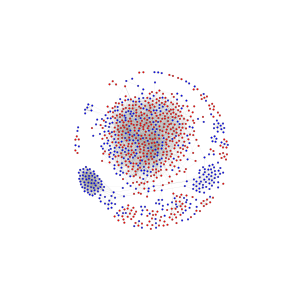

In [21]:
# stylized_network, config = visualize(G0)
stylized_network, config = visualize(G)

In [68]:
stylized_network_2, config_2 = visualize(G, config=config, )

In [75]:
stylized_network_3, config_3 = visualize(H, config=config, )

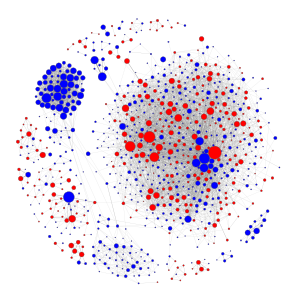

In [50]:
fig, ax = nw.draw_netwulf(stylized_network,)